# Predicting bike rental demand with random forests

In this notebook, I go through regression ML problem utilizing random forests. The <a href="http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset"> dataset</a> is from <a href="https://ride.capitalbikeshare.com/system-data">Capital BikeShare</a> and is hosted by the UCI ML repository, containing information about bike rentals. Our task will be to predict the number of bikes rented on a given day. First I load the necessary modules.
<br>
<br>

In [121]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

I read in the  data with pandas and parse the datetime column when reading so that this column will be in an appropriate datetime format, which will make it easier to process.

In [49]:
df=pd.read_csv('bikeshare.csv',parse_dates=['datetime'])

In [7]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
df.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

<br>
I will separate the date components into their own columns.
<br>
<br>

In [50]:
df['year']=df['datetime'].dt.year
df['month']=df['datetime'].dt.month
df['day']=df['datetime'].dt.day
df['weekday']=df['datetime'].dt.weekday
df['hour']=df['datetime'].dt.hour

In [25]:
df.head()
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,weekday,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,3.013963,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,2.004585,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,1.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,3.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,5.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,6.000000,23.000000


<br>
Nothing extraordinary sticks out for the values in each field so I do not drop any outliers or modifiy the values. Now that I have each date component as a separate column, I can drop the 'datetime' column. Since the year column has only 2 values, I will drop this as well since any trend over 2 data points won't be very informative. We need to predict the 'count' column, this column is the sum of the 'casual' and 'registered' columns. These two columns will not be available when trying to predict the demand on a future day, so I will drop the 'casual' and 'registered' columns as well.
<br>
<br>

In [51]:
df.drop(labels=['datetime','year','registered','casual'],axis=1,inplace=True)

In [33]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,day,weekday,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,1,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,40,1,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,32,1,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,13,1,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,1,1,1,5,4


In [34]:
df.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
month         0
day           0
weekday       0
hour          0
dtype: int64

<br>
The dataset looks fine so far, and it has no null values. I will now proceed to handle the categorical variables. The 'season' and 'weather' columns have multiple integer values each signifying a particular state of the respective field, e.g., a value of 1 in the season column means spring and 2 means summer. I will add a separate column for each of these states and use a 1 or 0 to denote if this state is present or not (onehot encoding).
<br>
<br>

In [106]:
df2=pd.get_dummies(df,columns=['season','weather'], drop_first=True)
df2.rename(columns={'season_2':'summer','season_3':'fall','season_4':'winter',
                                                   'weather_2':'mild','weather_3':'moderate','weather_4':'severe'},inplace=True)

In [103]:
df2.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,month,day,weekday,hour,season_1,summer,fall,winter,weather_1,mild,moderate,severe
0,0,0,9.84,14.395,81,0.0,16,1,1,5,0,1,0,0,0,1,0,0,0
1,0,0,9.02,13.635,80,0.0,40,1,1,5,1,1,0,0,0,1,0,0,0
2,0,0,9.02,13.635,80,0.0,32,1,1,5,2,1,0,0,0,1,0,0,0
3,0,0,9.84,14.395,75,0.0,13,1,1,5,3,1,0,0,0,1,0,0,0
4,0,0,9.84,14.395,75,0.0,1,1,1,5,4,1,0,0,0,1,0,0,0


Data processing is now complete, I will split the 'count' column from the rest of the dataset to get the target and feature tables.

In [104]:
y=df2['count']
features=df2.drop(['count'],axis=1)

<br>
I now instantiate a random forest regressor. I will be tuning the model using a randomized search and specify the distribution of the parameter grid as 'paramgrid'. I will use 15 iterations to search through this grid and cross validate each model using 4 folds using the root mean squared error to evalute the model. In this example I will tune the number of trees used in each model (n_estimators), the max depth of each tree (max_depth) and how the maximum number of features is determined when splitting at each node (max_features), the complete list of hyperparameter can be found in the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html"> sklearn documentation</a>. Ideally when tuning a model for production runs, we would like to explore a finer and bigger grid and repeat the tuning for multiple algorithms and pick the best one in the end.
<br>

In [112]:
rf=RandomForestRegressor()
paramgrid={'n_estimators':np.arange(50,200,20),'max_depth':np.arange(5,20,5),'max_features':['auto','sqrt']}

In [113]:
randsearch=RandomizedSearchCV(rf,param_distributions=paramgrid,scoring='neg_root_mean_squared_error',
                             cv=4,n_jobs=3,verbose=1,n_iter=15)

In [114]:
randsearch.fit(features,y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_iter=15, n_jobs=3,
                   param_distributions={'max_depth': array([ 5, 10, 15]),
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': array([ 50,  70,  90, 110, 130, 150, 170, 190])},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [115]:
randsearch.best_score_

-122.242351623502

<br>
Now that we have a tuned model, we can do a final test on a holdout set to make sure it can generalize well. Now I will use the best model from the tuning to examine which factors are most important when determining rental demand. For this I will use the 'best_estimator' attribute to select the best model and the 'feature_importances_' attribute to examine the importance of each feature for that model.
<br>

In [116]:
bestmodel=randsearch.best_estimator_

In [136]:
importances = pd.Series(data=bestmodel.feature_importances_,
                        index= features.columns)
importances_sorted = importances.sort_values()


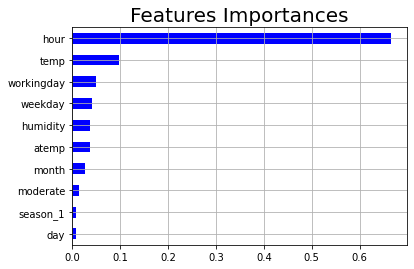

In [142]:
importances_sorted[-10:].plot(kind='barh', color='blue',grid=True)
plt.title('Features Importances',fontsize=20)
plt.show()

<br>
Above I plot the 10 most important features the model uses when determining bike rental demand, looks like the time of day and temperature are the most important factors! This can be useful information to the company when trying to supply sufficient bikes at each station.